# Module 3: MLOps and Real World Scenarios: Get Hands-On

## Part 1 - MLOps Deployment on a Structured Dataset
## Enter the world of Serverless Data Preparation, Model Training, and Model Serving

This notebook provides a comprehensive foundations for developing and deploying Machine Learning applications using the [MLRun](https://www.mlrun.org/) MLOps Orchestration Framework.

**Tutorial Steps:**
- [**Install MLRun and Dependencies**](#install-mlrun-dependencies)
- [**Configure MLRun Client Environment**](#configure-mlrun-client-environment)
- [**Define MLRun Project and Serverless Functions**](#define-mlrun-project-serverless-functions)
- [**Run Data Processing Serverless Function and Log Artifacts**](#run-dataset-generator-serverless-function)
- [**Auto-Train using MLRun's built-in Function Hub Serverless Functions**](#auto-train-mlrun-function-hub)
- [**Build, Test, and Deploy the Model Serving Functions**](#model-serving-functions)

<a id="install-mlrun-dependencies"></a>
## Install MLRun and Dependencies

This tutorial expects the MLRun backend service to be running on a Kubernetes Cluster.

**Note:** Throughout this tutorial, the GKE Cluster which was set up in Part 0 will be used to run the MLRun backend service.

In [82]:
# Ensure that Python 3 (preferred version: 3.9.x) and pip 22.x.y are installed on the machine.

# Check the Python version.
!python --version

# Check the pip version.
!python -m pip --version

Python 3.9.13
pip 22.3.1 from /opt/conda/lib/python3.9/site-packages/pip (python 3.9)


In [83]:
# Install MLRun and sklearn.

# Note: This cell needs to be run only once. The notebook needs to be restarted after a successful installation.

!python -m pip install mlrun scikit-learn~=1.3.0


[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


**Restart the notebook kernel after the pip installation.**

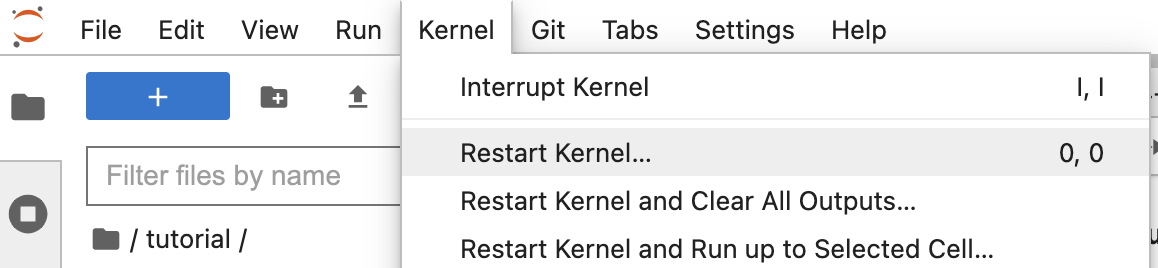

In [84]:
# Import the MLRun Python package.
import mlrun

<a id="configure-mlrun-client-environment"></a>
### Configure the MLRun Client Environment

MLRun client establishes connection with the MLRun backend service/cluster (could be hosted locally or remotely) using a REST API.

To configure the MLRun backend service address, required credentials, and default settings, `mlrun.set_environment()` method could be used.

**Note:** Environment Variables or MLRun CLI can also be used if MLRun Python SDK is not to be used. Check out the details at [Configure MLRun Client Environment](https://docs.mlrun.org/en/stable/install/remote.html) and [Configure Remote Connection](https://docs.mlrun.org/en/stable/cheat-sheet.html#remote-connection-laptop-ci-cd-etc).

In [85]:
# Configure MLRun Client Environment using MLRun CLI.

# Note: This step can be skipped when using out-of-the-box/packaged MLRun Jupyter notebooks.
# !mlrun config set -a https://<mlrun-api-endpoint>:<mlrun-api-endpoint-port>

<a id="define-mlrun-project-serverless-functions"></a>
## Define MLRun Project and Serverless Functions

### MLRun Projects
An [MLRun Project](https://docs.mlrun.org/en/stable/projects/project.html) is a container for all the work related to a particular activity or a Machine Learning application. An MLRun Project is capable of hosting `functions`, `workflow`, `artifacts`, `secrets`, `feature stores`, `models`, `metadata`, and much more.

MLRun Projects have access control and can be accessed by one or more users. MLRun Projects are usually associated with a GIT repository or an archive and interact with CI/CD frameworks for automation.

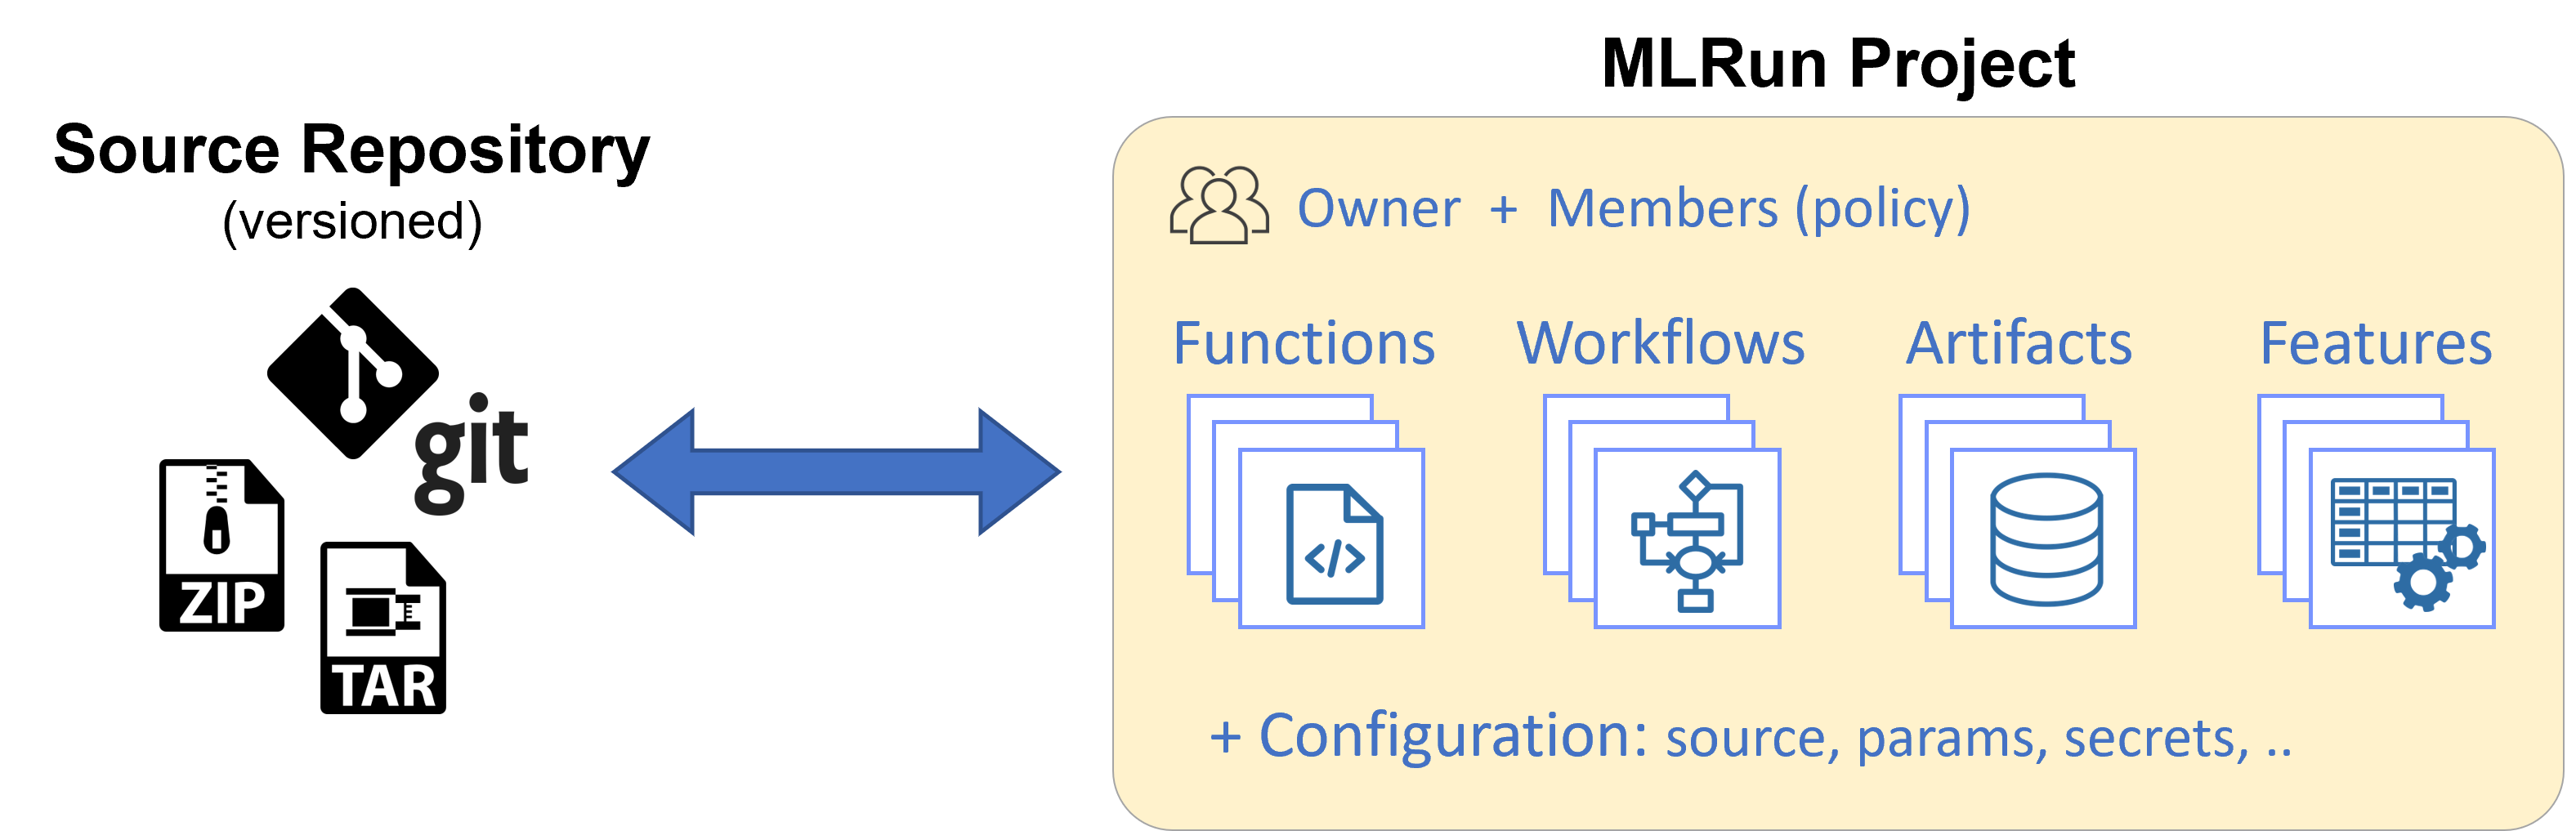

**Check out the command below to create a new MLRun Project.**

In [86]:
# Create a new MLRun Project.
# The function `mlrun.get_or_create_project()` can also be used to retrieve/load an existing MLRun Project, given the supporting arguments.
project = mlrun.get_or_create_project(name="quick-tutorial", context="./", user_project=True)

#Notes:
# `context` argument specifies the MLRun Project's local directory path (default value = “./”).
# When loading an MLRun Project, MLRun expects a `project.yaml` file with project definition and objects in the specified directory path so that the project
# can be initialized.
# File paths in the project are relative to the context root.

# Documentation for mlrun.get_or_create_project(): https://docs.mlrun.org/en/stable/api/mlrun.projects.html#mlrun.projects.get_or_create_project.

> 2023-08-04 09:41:41,499 [info] Project loaded successfully: {'project_name': 'quick-tutorial'}


**Note:** An MLRun Project can also be created from some pre-defined template, as shown below.

```
# Create a fresh MLRun Project from archive (zip), initialize a local git repository, and register the git remote path.
project = mlrun.new_project(name="myproj",
                            context="./",
                            init_git=True,
                            user_project=True,
                            remote="git://github.com/myorg/some-project.git",
                            from_template="http://mysite/proj.zip")

```

Check out the official documentation for more details on how to [create a new MLRun Project](https://docs.mlrun.org/en/stable/projects/create-project.html#creating-a-new-project).

#### Sample MLRun Project Directory Structure
```
my-project           # Parent directory of the project (context).
├── data             # Project data for local tests or outputs (not tracked by version control).
├── docs             # Project documentation.
├── src              # Project source code (functions, libs, workflows, etc.).
├── tests            # Unit tests (pytest) for the different Serverless Functions.
├── project.yaml     # MLRun Project specification file.
├── README.md        # Project README.
└── requirements.txt # Default Python requirements file (can have function specific requirements as well).
```

### MLRun Serverless Functions
[MLRun Serverless Functions](https://docs.mlrun.org/en/latest/runtimes/functions.html) specify the source code, base `image`, extra package `requirements`, runtime engine `kind` (batch `job`, real-time `serving`, `spark`, `dask`, etc.), and desired resources (cpu, gpu, mem, storage, etc.). The runtime engines (local, job, Nuclio, Spark, etc.) automatically transform the function code and spec into fully managed and elastic services that run over Kubernetes.
The Servlerless Function's source code can come from a single file (.py, .ipynb, etc.) or a full archive (git, zip, or tar).

MLRun is capable of executing an entire file/notebook or specific function classes/handlers.

#### MLRun Handler Decorator (@mlrun.handler)
```
The `@mlrun.handler` is a decorator that logs the returning values (as configured) to MLRun.

The followwing example uses the default settings so that it logs a dataset (`pd.DataFrame`) and a string value (specifying the returned object types). In addition to logging outputs, the `@mlrun.handler` decorator can parse incoming inputs to the required type.

```
For more information, the official documentation of [mlrun.handler](https://docs.mlrun.org/en/latest/api/mlrun.html#mlrun.handler) should be checked.


**The following cell generates a Python file (data-prep-digits.py) having the Data Loading and Preparation Serverless Function.**

In [87]:
%%writefile data-prep-digits.py
# The above line will write the contents of this Jupyter cell to a file named `data-prep-digits.py` in the current context.

# Import required Python packages.
import pandas as pd
from sklearn.datasets import load_digits

import mlrun

"""
digits Dataset: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits
Classes: 10
Samples per class: ~180
Samples total: 1797
Dimensionality: 64
Features: integers 0-16
"""

# Specify an MLRun Handler to log the dataset (as defined in the return statement; output of the function contains a dataset) in MLRun
# along with additional string value (specifying the returned object types).
@mlrun.handler(outputs=["dataset", "label_column"])
def digits_dataset_generator():
    """
    A function that generates and prepares sklearn digits dataset.
    """
    # Initialize the sklearn digits dataset.
    initialize_digits_dataset = load_digits() 

    # Create a DataFrame from the given data i.e. the digits classification data, along with all its default colums.
    digits_dataset = pd.DataFrame(data=initialize_digits_dataset.data, columns=initialize_digits_dataset.feature_names)
    
    # Create a DataFrame from the given data i.e. the digits classification target, and have the data put under a column named "label".
    # initialize_digits_dataset.target: {ndarray, Series} of shape (1797,).
    digits_dataset_labels = pd.DataFrame(data=initialize_digits_dataset.target, columns=["label"])
    
    # Concatenate the data horizontally so that the labels column gets added to the dataset.
    digits_dataset = pd.concat([digits_dataset, digits_dataset_labels], axis=1)

    return digits_dataset, "label"

Overwriting data-prep-digits.py


**Create a Serverless Function Object from the code above and register it in the MLRun Project.**

In [93]:
# Create (the same code can be used for updating as well) a Serverless Function Object for the Data Generation and Preparation code and register it in the MLRun Project.
data_gen_fn = project.set_function(
    func="data-prep-digits.py",
    name="data-prep-digits",
    kind="job",
    image="mlrun/mlrun",
    handler="digits_dataset_generator"
)
# The `project.set_function` returns a project object.

# Save the project with the latest configuration.
# The project.save() functions saves the project to the `project.yaml` file and in the database.
project.save()

> 2023-08-04 09:53:29,779 [warning] Failed to add git metadata, ignore if path is not part of a git repo.: {'path': './', 'error': '/home/jovyan/tutorial'}


```
# Register a (single) Python file as a Serverless Function.
project.set_function('src/data_prep.py', 'data-prep', image='mlrun/mlrun', handler='prep', kind="job")

# Register a notebook file as a Serverless Function.
# Custom image and extra requirements can be specified.
project.set_function('src/mynb.ipynb', name='test-function', image="my-org/my-image",
                      handler="run_test", requirements="requirements.txt", kind="job")

# Register a `module.handler` as a Serverless Function.
# This requires defining the default source/work directory, if it is not root.
project.spec.workdir = "src"
project.set_function(name="train", handler="training.train",  image="mlrun/mlrun", kind="job", with_repo=True)
# `with_repo=True` adds/clones the current repository to the build source.
```

<a id="run-dataset-generator-serverless-function"></a>
## Run Data Processing Serverless Function and Log Artifacts
Serverless Functions are executed (using the CLI or SDK **`run`** command) with an optional `handler`, various `params`, `inputs`, and resource requirements. This generates a `run` object that can be tracked through the CLI, UI, and SDK. Multiple Serverless Functions can be executed and tracked as part of a multi-stage pipeline (workflow). 

```
When a Serverless Function has additional package `requirements`, or needs to include the content of a `source` archive,
the function must first be build using the `project.build_function()` method.
```

The `local` flag indicates if the function is executed **locally** or "teleported" and executed in a **remote Kubernetes Cluster**. The execution progress and results can be viewed in the UI.

<br>

**Run the Data Generation and Preparation Serverless Function using the SDK, as shown below.**

In [95]:
# Run the Data Generation and Preparation Serverless Function.
# Make sure `local=False` if the Serverless Function is to be run on a remote Kubernetes Cluster.
gen_data_run = project.run_function("data-prep-digits", local=True)

> 2023-08-04 10:02:39,127 [info] Storing function: {'name': 'data-prep-digits-digits-dataset-generator', 'uid': '3a2c348504024734ab08930104e2c812', 'db': 'http://mlrun-api:8080'}


> 2023-08-04 10:02:40,445 [info] Run execution finished: {'status': 'completed', 'name': 'data-prep-digits-digits-dataset-generator'}


<br>

**Print the run state and outputs for the Data Generation and Preparation Serverless Function.**

In [96]:
# Get the run state of the Data Generation and Preparation Serverless Function.
gen_data_run.state()

'completed'

In [99]:
# Get the output of the Data Generation and Preparation Serverless Function, as defined in the `@mlrun.handler` decorator.
gen_data_run.outputs

{'label_column': 'label',
 'dataset': 'store://artifacts/quick-tutorial-jovyan/data-prep-digits-digits-dataset-generator_dataset:3a2c348504024734ab08930104e2c812'}

<br>

**Print the output dataset artifact (`DataItem` object) as a dataframe.**

In [101]:
# Print the output dataset artifact to check the data samples.
# It should be noted that the additional column `label` that was concatenated horizontally also appears in the output, as expected.
gen_data_run.artifact("dataset").as_df().head()

pixel_0_0  pixel_0_1  pixel_0_2  pixel_0_3  pixel_0_4  pixel_0_5  \
0        0.0        0.0        5.0       13.0        9.0        1.0   
1        0.0        0.0        0.0       12.0       13.0        5.0   
2        0.0        0.0        0.0        4.0       15.0       12.0   
3        0.0        0.0        7.0       15.0       13.0        1.0   
4        0.0        0.0        0.0        1.0       11.0        0.0   

   pixel_0_6  pixel_0_7  pixel_1_0  pixel_1_1  ...  pixel_6_7  pixel_7_0  \
0        0.0        0.0        0.0        0.0  ...        0.0        0.0   
1        0.0        0.0        0.0        0.0  ...        0.0        0.0   
2        0.0        0.0        0.0        0.0  ...        0.0        0.0   
3        0.0        0.0        0.0        8.0  ...        0.0        0.0   
4        0.0        0.0        0.0        0.0  ...        0.0        0.0   

   pixel_7_1  pixel_7_2  pixel_7_3  pixel_7_4  pixel_7_5  pixel_7_6  \
0        0.0        6.0       13.0       10.0        0.0        0.0   
1        0.0        0.0       11.0       16.0       10.0        0.0   
2        0.0        0.0        3.0       11.0       16.0        9.0   
3        0.0        7.0       13.0       13.0        9.0        0.0   
4        0.0        0.0        2.0       16.0        4.0        0.0   

   pixel_7_7  label  
0        0.0      0  
1        0.0      1  
2        0.0      2  
3        0.0      3  
4        0.0      4  

[5 rows x 65 columns]

<a id="auto-train-mlrun-function-hub"></a>
## Auto-Train using MLRun's built-in Function Hub Serverless Functions

MLRun provides a [Function Hub](https://www.mlrun.org/hub/) that hosts a set of pre-implemented and validated Serverless Functions. There are Serverless Functions for ETL, data preparation, training (ML & Deep learning), serving, alerts and notifications, and much more.

Functions can be easily imported into the MLRun Projects and therefore can help speed up the model development cycle by reusing built-in code.

More details about Function Hub can be found at the [official documentation](https://docs.mlrun.org/en/latest/runtimes/load-from-hub.html).

This tutorial uses the `auto-trainer` Function Hub Serverless Function that can train an ML model using a variety of ML frameworks, generate various metrics and charts, and log the model along with its metadata into the MLRun Model Registry.

In [105]:
# Import the Auto-Trainer Function Hub Serverless Function.
trainer = mlrun.import_function("hub://auto_trainer")


The `auto_trainer` function usage instructions can be checked at the [Auto-Trainer's official documentation](https://www.mlrun.org/hub/functions/master/auto_trainer/) or by typing `trainer.doc()`.

In [108]:
# Get Auto-Trainer's function usage documentation and instructions.
trainer.doc()

function: auto-trainer
Automatic train, evaluate and predict functions for the ML frameworks - Scikit-Learn, XGBoost and LightGBM.
default handler: train
entry points:
  train: Training the given model on the given dataset.
    context(MLClientCtx)  - MLRun context, default=
    dataset(DataItem)  - The dataset to train the model on. Can be either a URI or a FeatureVector, default=
    drop_columns(List[str])  - str or a list of strings that represent the columns to drop, default=None
    model_class(str)  - The class of the model, e.g. `sklearn.linear_model.LogisticRegression`, default=None
    model_name(str)  - The model's name to use for storing the model artifact, default to 'model', default=model
    tag(str)  - The model's tag to log with, default=
    label_columns(Optional[str, List[str]])  - The target label(s) of the column(s) in the dataset. for Regression or Classification tasks, default=None
    sample_set(DataItem)  - A sample set of inputs for the model for logging its 

**Check the cell below to configure and execute the Auto-Trainer Function Hub Serverless Function.**

In [111]:
# Configure and run the Auto-Trainer Function Hub Serverless Function.
# The function uses the generated/prepared digits dataset for training.
# Note; that the `train` function/handler of Auto-Trainer is being used.
trainer_run = project.run_function(
    function=trainer,
    inputs={"dataset": gen_data_run.outputs["dataset"]},
    params={
        "model_class": "sklearn.ensemble.RandomForestClassifier",
        "train_test_split_size": 0.2,
        "label_columns": "label",
        "model_name": "digits_classification"
    },
    handler="train"
)

> 2023-08-04 10:33:07,587 [info] Storing function: {'name': 'auto-trainer-train', 'uid': '6050e3ff1c4740909ddd4e5029dce37e', 'db': 'http://mlrun-api:8080'}
> 2023-08-04 10:33:07,920 [info] Job is running in the background, pod: auto-trainer-train-68mtk
> 2023-08-04 10:33:16,782 [info] Sample set not given, using the whole training set as the sample set
> 2023-08-04 10:33:17,450 [info] training 'digits_classification'
> 2023-08-04 10:33:23,302 [info] Run execution finished: {'status': 'completed', 'name': 'auto-trainer-train'}
final state: completed


> 2023-08-04 10:33:23,475 [info] Run execution finished: {'status': 'completed', 'name': 'auto-trainer-train'}


<br>

**View the job progress results and the selected run in the MLRun UI.**
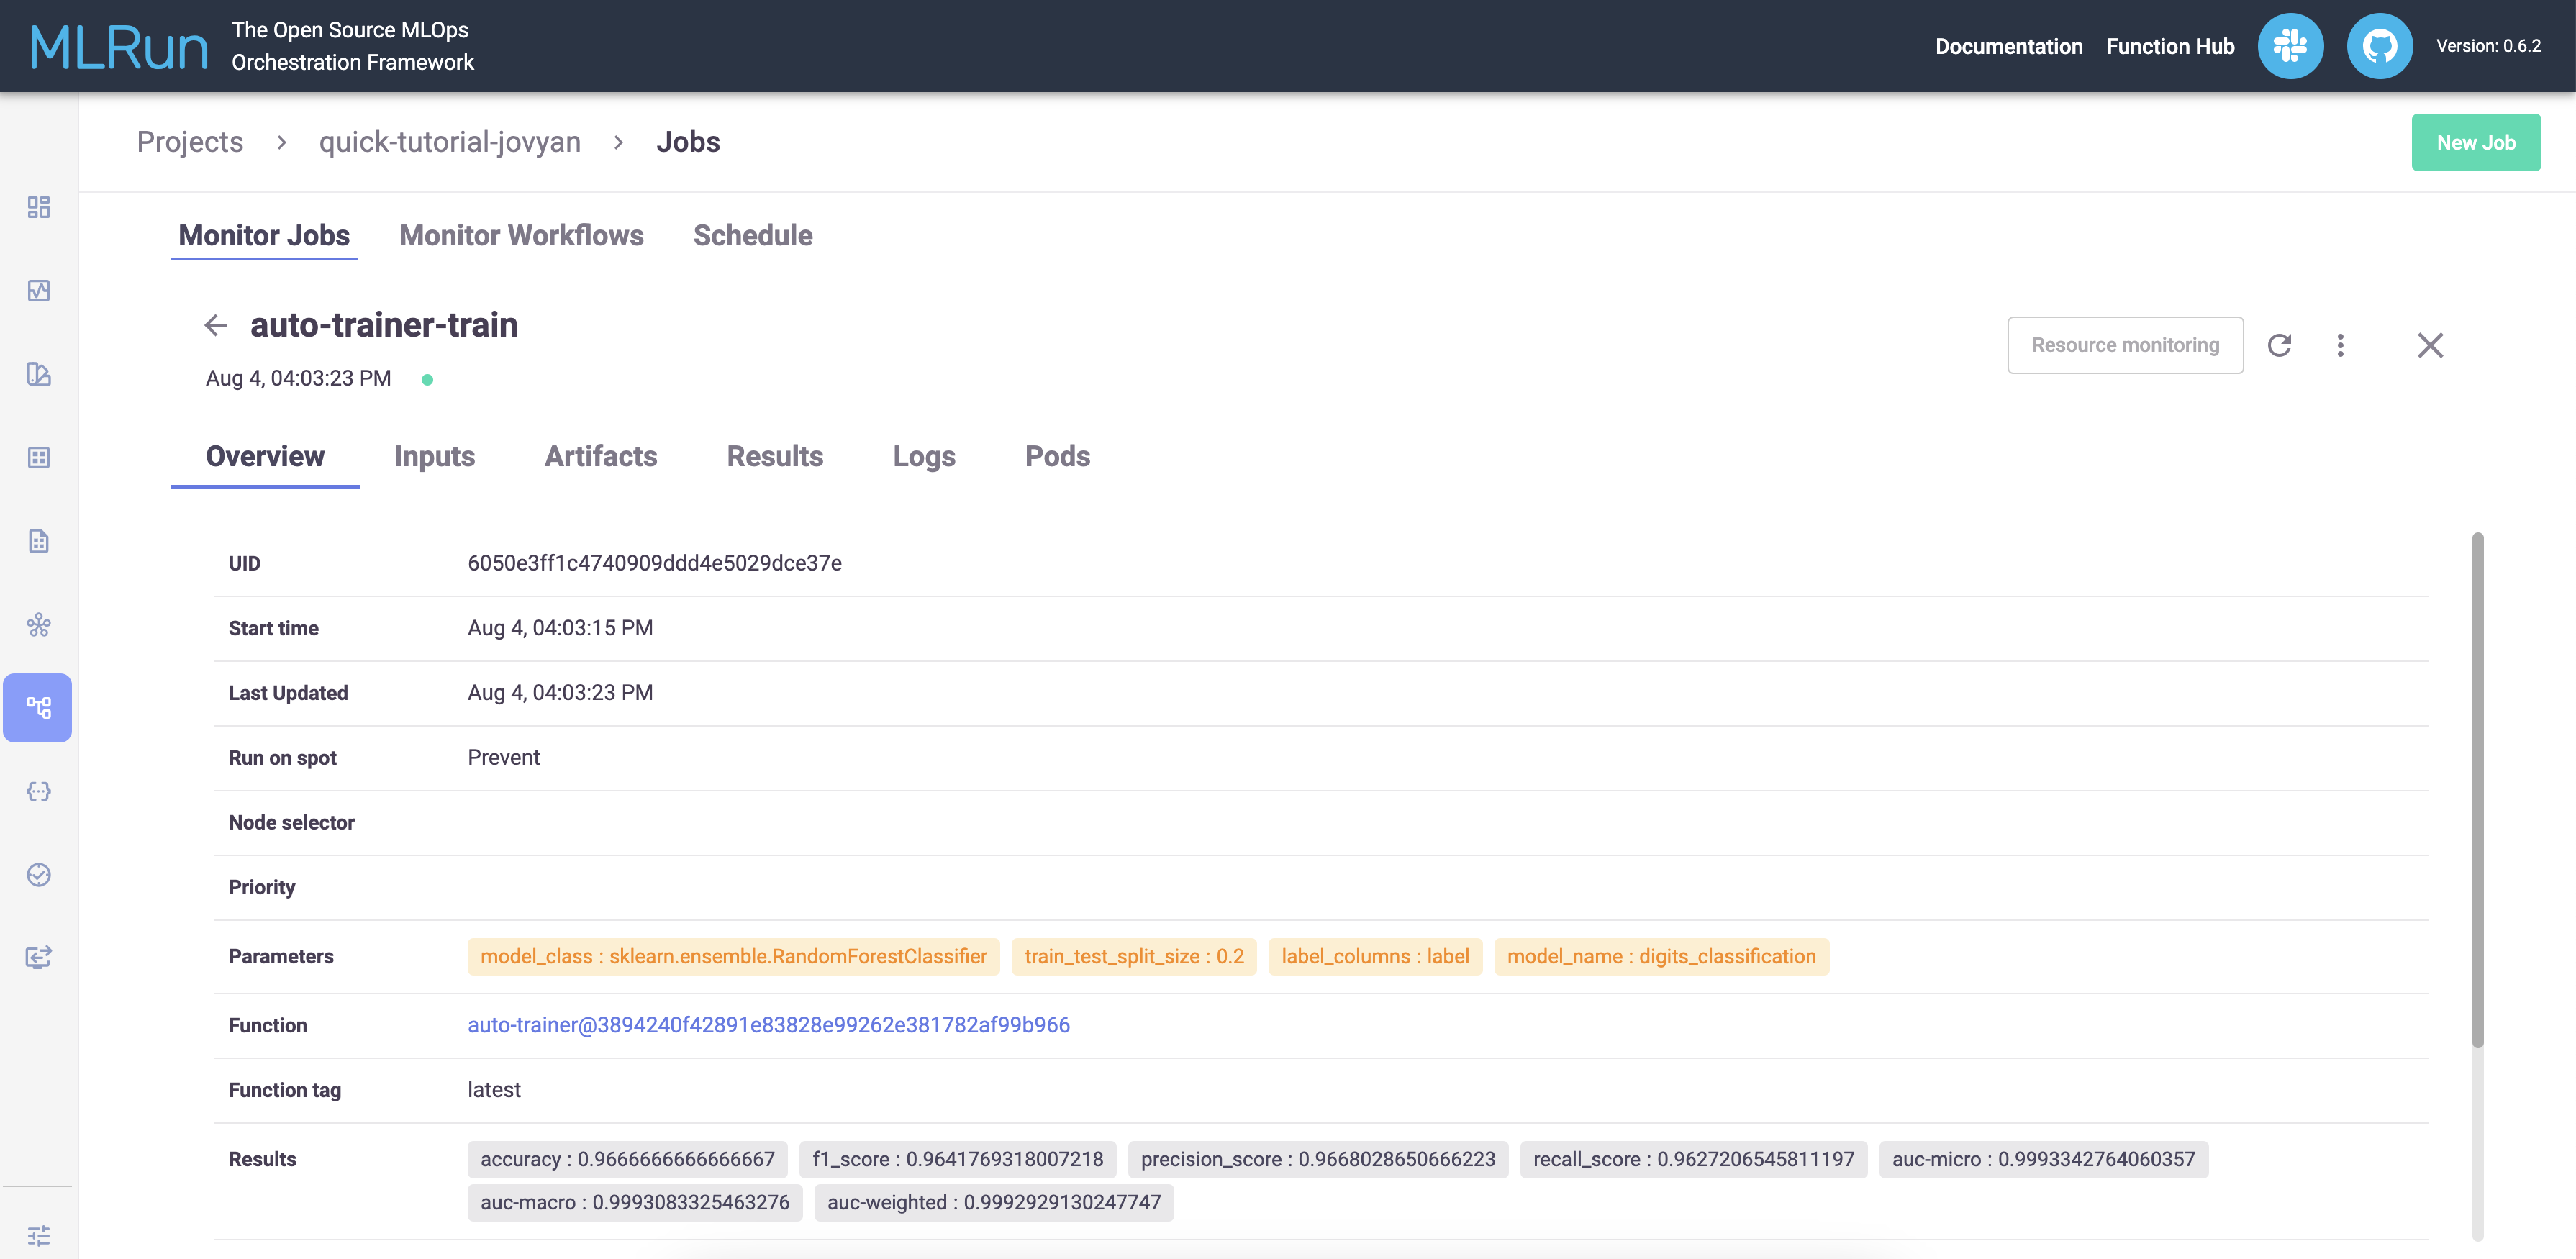

<br>

**Check the auto-generated and auto-tracked results (metrics) and artifacts for the training.**

In [113]:
# Check the auto-generated and auto-tracked training results and artifacts.
trainer_run.outputs

{'accuracy': 0.9666666666666667,
 'f1_score': 0.9641769318007218,
 'precision_score': 0.9668028650666223,
 'recall_score': 0.9627206545811197,
 'auc-micro': 0.9993342764060357,
 'auc-macro': 0.9993083325463276,
 'auc-weighted': 0.9992929130247747,
 'feature-importance': 's3://mlrun/projects/quick-tutorial-jovyan/artifacts/auto-trainer-train/0/feature-importance.html',
 'test_set': 'store://artifacts/quick-tutorial-jovyan/auto-trainer-train_test_set:6050e3ff1c4740909ddd4e5029dce37e',
 'confusion-matrix': 's3://mlrun/projects/quick-tutorial-jovyan/artifacts/auto-trainer-train/0/confusion-matrix.html',
 'roc-curves': 's3://mlrun/projects/quick-tutorial-jovyan/artifacts/auto-trainer-train/0/roc-curves.html',
 'model': 'store://artifacts/quick-tutorial-jovyan/digits_classification:6050e3ff1c4740909ddd4e5029dce37e'}

In [115]:
# Display the Confusion Matrix.
trainer_run.artifact("confusion-matrix").show()

<a id="model-serving-functions"></a>
## Build, Test, and Deploy the Model Serving Functions

MLRun Serving (more details covered in the following notebooks) feature can produce managed, real-time, serverless, pipelines composed of various data processing and ML tasks. The trained models can be served and deployed through dedicated endpoints.

The pipelines use [Nuclio](https://nuclio.io/https://nuclio.io/) as the Real-Time Serverless Engine, which can be deployed anywhere.

For more details about MLRun Service, check out [MLRun Serving Graphs](https://docs.mlrun.org/en/stable/serving/serving-graph.html).

**The following cell shows how to create a model Serving Serverless Function.**

In [120]:
# Create a model Servig Serverless Function.
serving_fn = mlrun.new_function(
    name="serving",
    image="python:3.9",
    kind="serving",
    requirements=["mlrun[complete]", "scikit-learn~=1.3.0"],
)

### Associate Model with the Serving Serverless Function

The basic serving topology supports a router with multiple child models attached to it.
The `function.add_model()` method allows adding models and specifying the `name`, `model_path` (to a model file, directory, or artifact), and the serving `class` (built-in or user defined).

In [121]:
# Add a model to the Serving Serverless Function.
serving_fn.add_model(
    key="digits_classifier",
    model_path=trainer_run.outputs["model"],
    class_name="mlrun.frameworks.sklearn.SklearnModelServer"
)

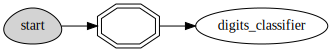

In [122]:
# Plot the Serving graph topology.
serving_fn.spec.graph.plot(rankdir="LR")

**The following cell simulates the model serving locally.**

In [123]:
# Create a mock (simulator of the real-time function) server.
server = serving_fn.to_mock_server()

> 2023-08-04 11:03:04,115 [warning] run command, file or code were not specified
> 2023-08-04 11:03:04,311 [info] model digits_classifier was loaded
> 2023-08-04 11:03:04,313 [info] Loaded ['digits_classifier']


<br>

**Test the mock model server endpoint.**
    
- List the served model(s).

In [132]:
# Verify that the mock model server endpoint is having the `digits_classifier` model listed.
server.test("/v2/models/", method="GET")

{'models': ['digits_classifier']}

- Infer using some test data.

In [37]:
# 
my_data = {    "inputs": [
        [
            0.0,
            0.0,
            0.0,
            1.0,
            11.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            7.0,
            8.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            1.0,
            13.0,
            6.0,
            2.0,
            2.0,
            0.0,
            0.0,
            0.0,
            7.0,
            15.0,
            0.0,
            9.0,
            8.0,
            0.0,
            0.0,
            5.0,
            16.0,
            10.0,
            0.0,
            16.0,
            6.0,
            0.0,
            0.0,
            4.0,
            15.0,
            16.0,
            13.0,
            16.0,
            1.0,
            0.0,
            0.0,
            0.0,
            0.0,
            3.0,
            15.0,
            10.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            2.0,
            16.0,
            4.0,
            0.0,
            0.0,
        ]
    ]
}
server.test("/v2/models/digits_classifier/infer", body=my_data)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


{'id': '6bf0d12301d849589485131b3339226a',
 'model_name': 'digits_classifier',
 'outputs': [4]}

- Read the model name, ver and schema (input and output features)

**Deploy a real-time serving function (over Kubernetes or Docker)**

This section requires Nuclio to be installed (over k8s or Docker).

Use the mlrun `deploy_function()` method to build and deploy a Nuclio serving function from your serving-function code.
You can deploy the function object (`serving_fn`) or reference pre-registered project functions.

In [41]:
project.deploy_function(serving_fn)

> 2023-08-03 13:08:14,006 [info] Starting remote function deploy
2023-08-03 13:08:14  (info) Deploying function
2023-08-03 13:08:14  (info) Building
2023-08-03 13:08:14  (info) Staging files and preparing base images
2023-08-03 13:08:14  (info) Building processor image
2023-08-03 13:08:18  (info) Build complete
2023-08-03 13:08:28  (info) Function deploy complete
> 2023-08-03 13:08:35,643 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-quick-tutorial-jovyan-serving.mlrun.svc.cluster.local:8080'], 'external_invocation_urls': ['34.27.249.238:30067']}


DeployStatus(state=ready, outputs={'endpoint': 'http://34.27.249.238:30067', 'name': 'quick-tutorial-jovyan-serving'})

- Test the live endpoint

In [39]:
serving_fn.invoke("/v2/models/digits_classifier/infer", body=my_data)

> 2023-08-03 13:07:08,658 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-quick-tutorial-jovyan-serving.mlrun.svc.cluster.local:8080/v2/models/digits_classifier/infer'}


{'id': 'f24550d2-6dad-4957-a89f-e996527be65e',
 'model_name': 'digits_classifier',
 'outputs': [4]}

## Part 1 Completed!

Congratulations! You've completed Part 1 of the Module 3: MLOps and Real World Scenarios.
Proceed to Part 2 to try out MLOps Deployment with Computer Vision.